In [7]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# This uses the Answers.csv file from the 10% Stack Overflow data
answer_file = "Answers.csv"
# This edge list is the intermediate file used for graph building
edges_list_file = "answer_edges.txt"

## Pre-processing

In [12]:
# loads data with pands, it eats up memory, but parsing with pyspark is much more work
df = pd.read_csv("Answers.csv", encoding="ISO-8859-1")
df.head(5)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."


In [13]:
df.shape

(2014516, 6)

In [14]:
df.loc[df['ParentId'] == 90]


,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
10748,202317,20709.0,2008-10-14T18:41:45Z,90,2,"<p>You can also try <em><a href=""http://www.co..."
85572,1466832,16012.0,2009-09-23T15:40:46Z,90,19,<p>My easy click-by-click instructions (<stron...


In [15]:
# Question_ids and user_ids may overlap, but that does not mean questions are users!!!
# Soln: each question_id += max_user_id
max_user_id = df[['OwnerUserId']].max()
max_user_id

OwnerUserId    7045028.0
dtype: float64

In [16]:
edge_df = df[['OwnerUserId', 'ParentId']]
# 1. drop null values
edge_df = edge_df.dropna()
# 2. make parentIds unique
edge_df = edge_df.assign(newParentId=lambda x: x.ParentId + max(max_user_id))
edge_df = edge_df.drop(['ParentId'], axis=1)
# 3. add weights to edges
edge_df['EdgeWeight'] = 1
# 4. cast the datafraem to int type
edge_df = edge_df.astype('int32')
edge_df.head(30)

,OwnerUserId,newParentId,EdgeWeight
0,61,7045118,1
1,26,7045108,1
2,50,7045208,1
3,91,7045288,1
4,49,7045288,1
5,59,7045358,1
6,100,7045288,1
7,119,7045288,1
8,49,7045498,1
9,86,7045208,1


In [17]:
edge_df.loc[edge_df['newParentId'] == 7045118]

,OwnerUserId,newParentId,EdgeWeight
0,61,7045118,1
10748,20709,7045118,1
85572,16012,7045118,1


In [18]:
edge_df.to_csv('answer_edges.txt', sep=' ', header=False, index=False)


## Build Graph

In [19]:
# by default, nx creates undirected edges, exactly what we want
G = nx.read_edgelist(edges_list_file, nodetype=int, data=(('weight',float),))
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1568735
Number of edges: 1993272
Average degree:   2.5412


In [20]:
all_user_ids = set()
all_question_ids = set()
with open(edges_list_file, 'r') as read_file:
    for line in read_file.readlines():
        user_id, question_id, weight = line.strip().split(' ')
        all_user_ids.add(int(user_id))
        all_question_ids.add(int(question_id))
print(list(all_user_ids)[:10])
print(list(all_question_ids)[:10])
# should be no intersection between user_ids and question_ids
print(len(all_user_ids.intersection(all_question_ids)))


[1, 3, 4, 5, 1048579, 2097159, 5242883, 9, 3145739, 1048588]
[18874368, 39845888, 37748738, 25165828, 35651588, 12582918, 46137348, 41943048, 8388618, 14680078]
0


In [21]:
# General Data Analysis
islands = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print("connected components", islands[:10])

connected components [1328544, 53, 36, 34, 34, 29, 28, 27, 25, 24]


In [22]:
# analyze how connected the graph is
# connectivity of 0..... oh well
from networkx.algorithms import approximation as approx
approx.node_connectivity(G)

0

## Test Performance

In [23]:
import random
from collections import Counter
# parameters
n_test_edge = 1000
n_steps = 1000
teleportation_alpha = 0.3
early_stop_threshold = 20

# returns whether x2 - y2 edge is the same as x1 - y1 edge
# is_same_edge(1, 2, 2, 1) == is_same_edge(1, 2, 1, 2) == True
def is_same_edge(x1, y1, x2, y2):
    if x1 == x2:
        return y1 == y2
    elif x1 == y2:
        return y1 == x2
    return False

# a random walk on the user_node (x or y)
# pretend the direct edge (x, y) does not exist
# returns a distribution of questions nodes
def random_walk_on_edge(x, y, teleportation_alpha):
    # curr_pos is always on user nodes
    starting_pos = x if x in all_user_ids else y
    curr_pos = starting_pos
    reacheable_count = Counter()
    for s in range(n_steps):
        try:
            potential_questions_nodes = random.sample(set(G[curr_pos]), 2)
            question_node = potential_questions_nodes[0] if not is_same_edge(x, y, potential_questions_nodes[0], curr_pos) else potential_questions_nodes[1]
            # diff from pinterest algorithm in that we care about questions, not users
            reacheable_count[question_node] += 1
            if sum(reacheable_count.values()) / len(reacheable_count.values()) >= early_stop_threshold:
                # if average > early_stop_threshold, stop
                print('early stopping!')
                break
            potential_user_nodes = random.sample(set(G[question_node]), 2)
            user_node = potential_user_nodes[0] if not is_same_edge(x, y, potential_user_nodes[0], question_node) else potential_user_nodes[1]
            if random.random() < teleportation_alpha:
                curr_pos = starting_pos
            else:
                curr_pos = user_node
        except ValueError:
            # encouter valueError during random.sample when population is smaller than 2
            # This only happens if we reached a deadend
            # simply teleport back
            curr_pos = starting_pos
    # calculate distribution
    tot_visits = sum(reacheable_count.values())
    # sort visits by counts
    all_visits = sorted(reacheable_count.items(), key=lambda x: x[1], reverse = True)
    
    return all_visits, [(i[0], i[1] / tot_visits) for i in all_visits]



In [24]:
all_edges = list(G.edges())
all_edges[:10]

[(61, 7045118),
 (61, 7069298),
 (61, 7093008),
 (61, 7096418),
 (61, 7187368),
 (61, 7571688),
 (61, 8626588),
 (61, 9565248),
 (61, 13287568),
 (61, 13598978)]

In [186]:
print(G[61])
print(list(G[61]))

{7045118: {'weight': 1.0}, 7069298: {'weight': 1.0}, 7093008: {'weight': 1.0}, 7096418: {'weight': 1.0}, 7187368: {'weight': 1.0}, 7571688: {'weight': 1.0}, 8626588: {'weight': 1.0}, 9565248: {'weight': 1.0}, 13287568: {'weight': 1.0}, 13598978: {'weight': 1.0}}
[7045118, 7069298, 7093008, 7096418, 7187368, 7571688, 8626588, 9565248, 13287568, 13598978]


In [187]:
visit, test_distr = random_walk_on_edge(61, 7045118)
print(test_distr[:10])
print(len(test_distr))
print([i for i in test_distr if i[0] == 7045118])

[(7187368, 0.07468879668049792), (8626588, 0.06535269709543569), (13287568, 0.06224066390041494), (7069298, 0.05912863070539419), (9565248, 0.056016597510373446), (7571688, 0.056016597510373446), (7096418, 0.0508298755186722), (7093008, 0.04979253112033195), (13598978, 0.0487551867219917), (12607028, 0.00933609958506224)]
389
[]


In [188]:
import random
random.sample(set(G[61]), 2)

[7045118, 13598978]

# Evaluation
- Run 2000 random edges and check if the hidden question is in the recommendation list. 

In [26]:
(edge_df.groupby(["newParentId"])["OwnerUserId"]
 .count().reset_index(name='count') 
 .sort_values(['count'], ascending=False) 
 .head(4))

,newParentId,count
5842,7451788,384
420,7083238,300
241,7068958,118
1194,7145448,96


In [27]:
question_user_df = edge_df.groupby(["newParentId"])["OwnerUserId"].apply(list).reset_index(name="user_list")
question_user_df["num_user"] = question_user_df["user_list"].apply(lambda x: len(x))
question_user_df["user"] = question_user_df["user_list"].apply(lambda x: random.sample(x,1)[0])
question_user_df.head(5)

,newParentId,user_list,num_user,user
0,7045108,"[26, 1109, 364174]",3,26
1,7045118,"[61, 20709, 16012]",3,16012
2,7045148,[12734],1,12734
3,7045208,"[50, 86, 157, 5845, 16632, 16582, 115432, 6784...",9,50
4,7045288,"[91, 49, 100, 119, 541, 905, 12713, 192536, 91...",9,12713


In [28]:
from collections import Counter
user_bin = Counter(list(question_user_df["num_user"]))
user_percentage = [(y,x/sum(user_bin.values())) for x,y in zip(user_bin.values(), user_bin.keys())]
user_percentage= sorted(user_percentage, key = lambda x: x[1], reverse =True)
user_percentage[:5]

[(1, 0.5516192730863012),
 (2, 0.2583127412635985),
 (3, 0.1060896159601723),
 (4, 0.044177944575057866),
 (5, 0.019486552878434968)]

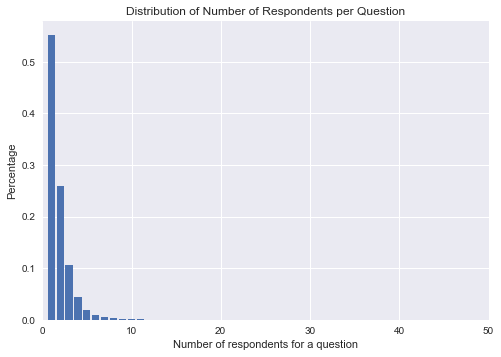

In [311]:
x = [i[0] for i in user_percentage]
y = [i[1] for i in user_percentage]
plt.bar(x,y)
plt.xlim(0,50)
plt.xlabel("Number of respondents for a question")
plt.ylabel("Percentage")
plt.title("Distribution of Number of Respondents per Question")
plt.show()

## User distribution 

In [302]:
user_question_df = edge_df.groupby(["OwnerUserId"])["newParentId"].apply(list).reset_index(name="question_list")
user_question_df["num_question"] = user_question_df["question_list"].apply(lambda x: len(x))
user_question_df.head(5)

,OwnerUserId,question_list,num_question
0,1,"[7046038, 7055638, 7058498, 7077038, 7431408, ...",13
1,3,"[7337858, 7323918, 7312058, 7571918, 21503818,...",6
2,4,"[7305288, 7457948, 7593548, 7757498, 11450488,...",19
3,5,"[7053078, 7055288, 7057908, 7058568, 7049258, ...",26
4,9,"[7056848, 7235968, 7776068, 7652668, 22507728,...",6


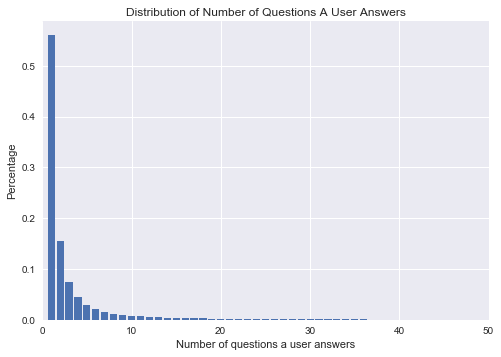

In [312]:
question_bin = Counter(list(user_question_df["num_question"]))
question_percentage = [(y,x/sum(question_bin.values())) for x,y in zip(question_bin.values(), question_bin.keys())]
question_percentage= sorted(question_percentage, key = lambda x: x[1], reverse =True)
x = [i[0] for i in question_percentage]
y = [i[1] for i in question_percentage]
plt.bar(x,y)
plt.xlim(0,50)
plt.xlabel("Number of questions a user answers")
plt.ylabel("Percentage")
plt.title("Distribution of Number of Questions A User Answers")
plt.show()

In [307]:
question_percentage[:5]

[(1, 0.5604046100977609),
 (2, 0.15507991732029003),
 (3, 0.07523512309165802),
 (4, 0.044870167684520165),
 (5, 0.02977834755768488)]

## Tune teleport alpha 

early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early st

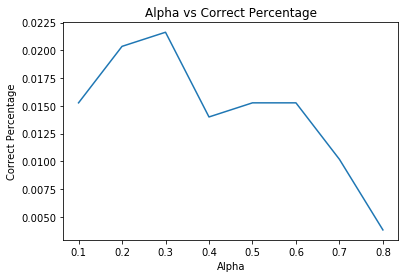

In [30]:
tune_alpha_df = question_user_df[question_user_df["num_user"] >= 15]

correct_percentage = []
for alpha in np.arange(0.1, 0.9, 0.1):
    count = 0
    for question, user in zip(tune_alpha_df.newParentId, tune_alpha_df.user):
        _, test_distr = random_walk_on_edge(user, question, alpha)
        count += len([i for i in test_distr if i[0] == question])>=1
    correct_percentage.append(count/tune_alpha_df.shape[0])
    
plt.plot(np.arange(0.1, 0.9, 0.1), correct_percentage)
plt.title("Alpha vs Correct Percentage")
plt.xlabel("Alpha")
plt.ylabel("Correct Percentage")
plt.show()

## Evaluation on different number of answerers

In [31]:
result = {}
for num_answerer in np.arange(10, 50, 5):
    temp_df = question_user_df[question_user_df["num_user"] >= num_answerer]
    
    correct_percentage = []
    for alpha in np.arange(0.2, 0.8, 0.1):
        count = 0
        for question, user in zip(temp_df.newParentId, temp_df.user):
            _, test_distr = random_walk_on_edge(user, question, alpha)
            count += len([i for i in test_distr if i[0] == question])>=1
        correct_percentage.append(count/temp_df.shape[0])
    result[num_answerer] = correct_percentage
    print(result)

early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early st

early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early st

early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early st

early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early st

early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early stopping!
early st

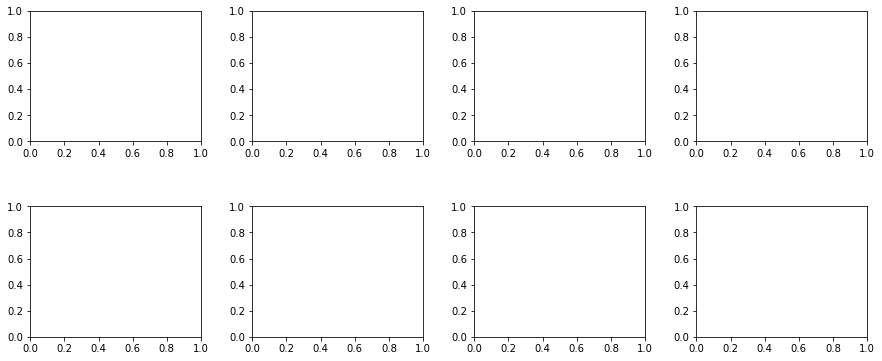

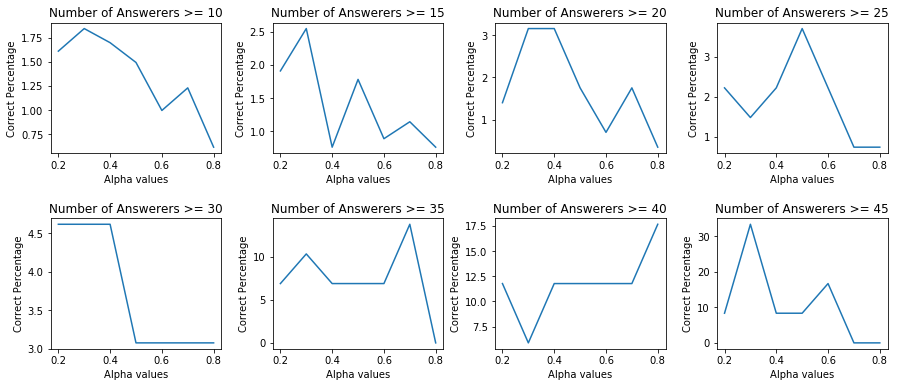

In [33]:
fig, axs = plt.subplots(2,4, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.3)

answerer_list = np.arange(10, 50, 5)
axs = axs.ravel()
for i in range(0,8):
    axs[i].plot(list(np.arange(0.2, 0.8, 0.1)), [i*100 for i in result[answerer_list[i]]])
    axs[i].set_title("Number of Answerers >= {}".format(str(answerer_list[i])))
    axs[i].set(xlabel='Alpha values', ylabel='Correct Percentage')
plt.show()